In [48]:
import numpy as np
import pandas as pd
import ast
from itertools import combinations
import requests
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
# GitHub API URL
url = 'https://api.github.com/repos/Razelbaz1/Primacy-and-Recency-Bias/contents/Data'
# Checking access to the site
response = requests.get(url)
data = response.json()

In [50]:
response

<Response [200]>

In [51]:
# Creating a list of relevant links
csv_files = [file['download_url'] for file in data if file['name'].endswith('.csv')]

In [52]:
csv_files

['https://raw.githubusercontent.com/Razelbaz1/Primacy-and-Recency-Bias/master/Data/rank_a_noiseless_new.csv',
 'https://raw.githubusercontent.com/Razelbaz1/Primacy-and-Recency-Bias/master/Data/s1_rank_annony.csv',
 'https://raw.githubusercontent.com/Razelbaz1/Primacy-and-Recency-Bias/master/Data/s2_rank_annony.csv',
 'https://raw.githubusercontent.com/Razelbaz1/Primacy-and-Recency-Bias/master/Data/s3_rank_annony.csv',
 'https://raw.githubusercontent.com/Razelbaz1/Primacy-and-Recency-Bias/master/Data/s4_rank_annony.csv',
 'https://raw.githubusercontent.com/Razelbaz1/Primacy-and-Recency-Bias/master/Data/s6_rank_annony.csv']

In [53]:
# Function to parse list_rank column
def parse_list_rank(row):
    return ast.literal_eval(row)

# Function to calculate lag values directly
def calculate_lag(group1, group2):
    return abs(group1 - group2)

all_combined_dfs = []

In [54]:
# Process each CSV file
for session_id, csv_url in enumerate(csv_files, start=1):
    # Load the CSV file
    data = pd.read_csv(csv_url)
    
    # Parse the list_rank column
    data['parsed_rank'] = data['list_rank'].apply(parse_list_rank)

    # Extract participant ID and their rankings
    parsed_data = []

    for _, row in data.iterrows():
        username = row['username']
        ranks = row['parsed_rank']
        
        for group, score in ranks:
            parsed_data.append({
                'username': username,
                'group': group,
                'score': score
            })

    # Create a DataFrame from the parsed data
    parsed_df = pd.DataFrame(parsed_data)

    # Find pairs with the same score and calculate lag
    lag_data = []

    for username, group_df in parsed_df.groupby('username'):
        same_score_groups = group_df.groupby('score')
        
        for score, score_df in same_score_groups:
            # Get all combinations of pairs
            for row1, row2 in combinations(score_df.itertuples(index=False), 2):
                lag_value = calculate_lag(row1.group, row2.group)
                
                # Determine primacy or recency
                if row1.group > row2.group:
                    bias = 'recency'
                else:
                    bias = 'primacy'
                
                lag_data.append({
                    'username': username,
                    'group1': row1.group,
                    'group2': row2.group,
                    'score': score,
                    'lag': lag_value,
                    'bias': bias
                })

    # Create a DataFrame for the lag data
    lag_df = pd.DataFrame(lag_data)

    # Split the bias column into 'primacy' and 'recency' columns
    lag_df['primacy'] = lag_df['bias'].apply(lambda x: 1 if x == 'primacy' else 0)
    lag_df['recency'] = lag_df['bias'].apply(lambda x: 1 if x == 'recency' else 0)

    # Final table structure
    final_df = lag_df[['username', 'score', 'lag', 'primacy', 'recency']].copy()
    final_df.loc[:, 'session_id'] = session_id  # Add the session_id column

    # Group by 'username', 'score', 'lag', and 'session_id' and aggregate 'primacy' and 'recency' columns
    combined_df = final_df.groupby(['username', 'score', 'lag', 'session_id']).agg({
        'primacy': 'sum',
        'recency': 'sum'
    }).reset_index()

    all_combined_dfs.append(combined_df)

In [87]:
# Concatenate all combined DataFrames
final_combined_df = pd.concat(all_combined_dfs, ignore_index=True)

# Group by lag and score
#grouped_df = final_combined_df.groupby(['username','session_id','lag','score']).agg({
#    'primacy': 'sum',
#    'recency': 'sum'
#}).reset_index()

# Display the grouped DataFrame
#print(grouped_df.head())

In [85]:
# Group by lag and score
grouped_df = final_combined_df.groupby(['lag','score']).agg({
    'primacy': 'sum',
    'recency': 'sum'
}).reset_index()

# Display the grouped DataFrame
print(grouped_df.head())

   lag  score  primacy  recency
0    1      2        2        0
1    1      3       25       21
2    1      4       75       81
3    1      5       69       96
4    2      2        2        1


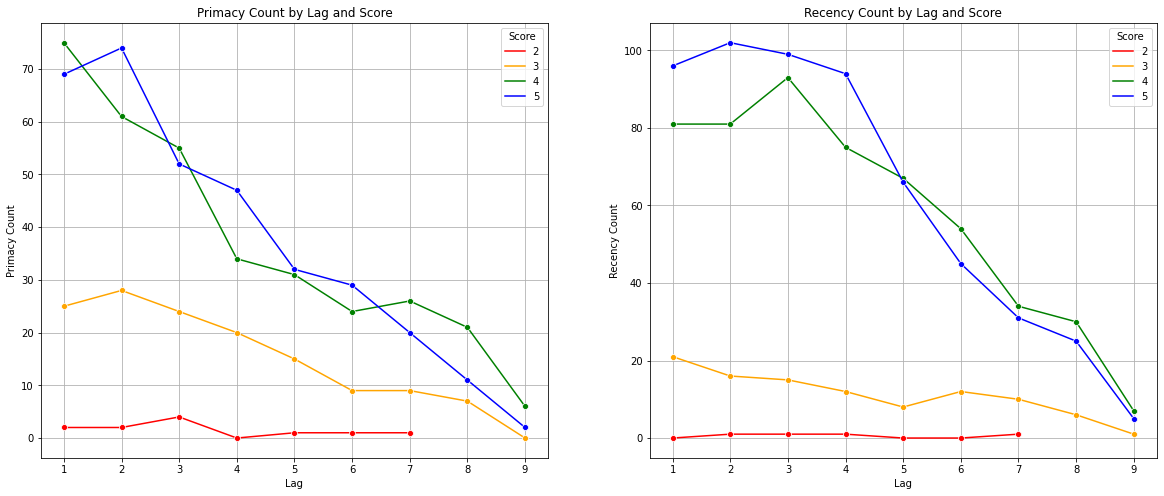

In [86]:
custom_palette = {
    5: "blue",
    4: "green",
    3: "orange",
    2: "red",
    1: "purple"
}

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

#  primacy lineplot
sns.lineplot(ax=axes[0], data=grouped_df, x='lag', y='primacy', hue='score', marker='o',palette= custom_palette, ci=False)
axes[0].set_title('Primacy Count by Lag and Score')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Primacy Count')
axes[0].legend(title='Score')
axes[0].grid(True)

# recency lineplot
sns.lineplot(ax=axes[1], data=grouped_df, x='lag', y='recency', hue='score', palette=custom_palette, marker='o', ci=False)
axes[1].set_title('Recency Count by Lag and Score')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Recency Count')
axes[1].legend(title='Score')
axes[1].grid(True)

plt.show()


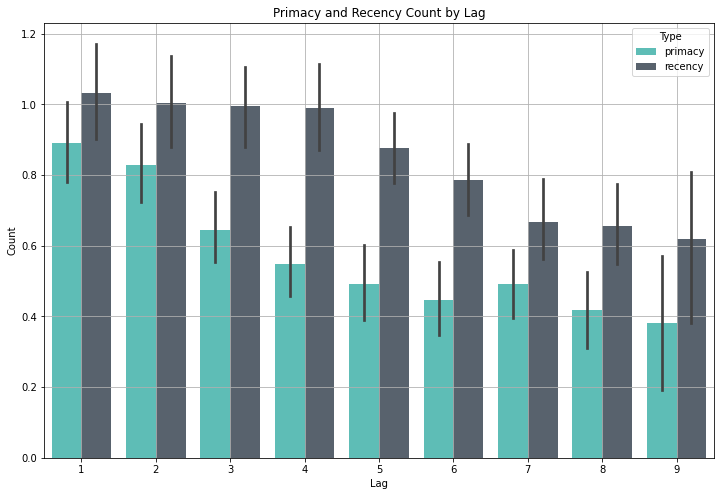

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# יצירת עמודות מסודרות לפי lag ו- primacy ו- recency
grouped_counts = grouped_df.melt(id_vars=['lag'], value_vars=['primacy', 'recency'], 
                                 var_name='Type', value_name='Count')

# יצירת ה-barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_counts, x='lag', y='Count', hue='Type', palette=['#4ECDC4', '#556270'])

# הגדרות נוספות לגרף
plt.title('Primacy and Recency Count by Lag')
plt.xlabel('Lag')
plt.ylabel('Count')
plt.legend(title='Type')
plt.grid(True)

# הצגת הגרף
plt.show()


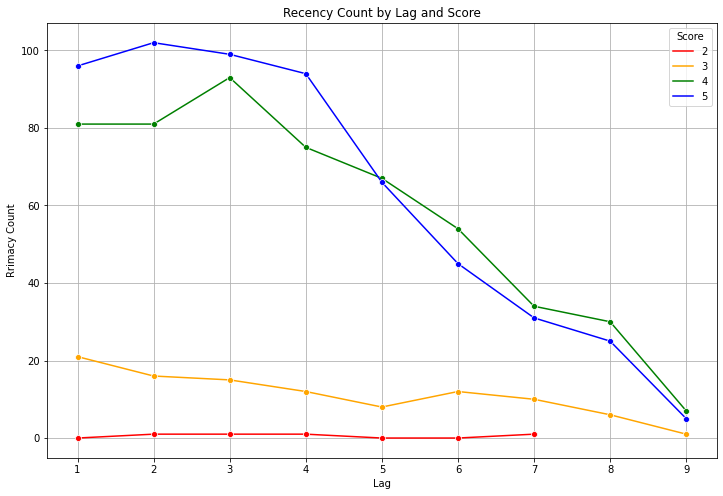

In [88]:
custom_palette = {
    5: "blue",
    4: "green",
    3: "orange",
    2: "red",
    1: "purple"
}


# lineplot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_df, x='lag', y='recency', hue='score', marker='o',palette= custom_palette, ci=False)

plt.title('Recency Count by Lag and Score')
plt.xlabel('Lag')
plt.ylabel('Rrimacy Count')
plt.legend(title='Score')
plt.grid(True)
plt.show()


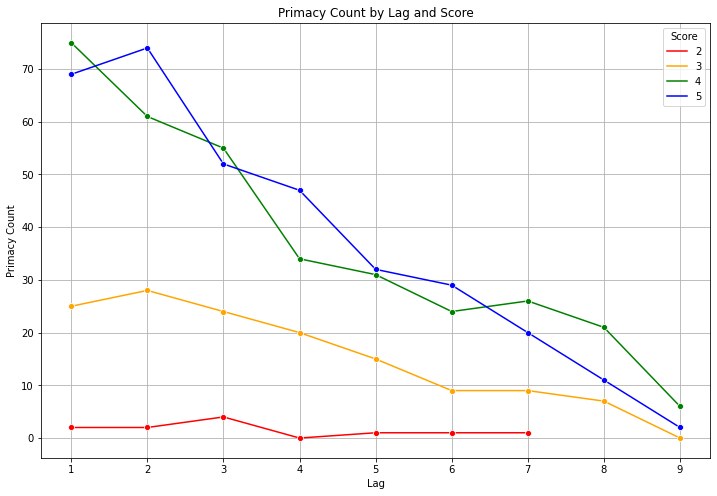

In [89]:
custom_palette = {
    5: "blue",
    4: "green",
    3: "orange",
    2: "red",
    1: "purple"
}


# lineplot
plt.figure(figsize=(12, 8))
sns.lineplot(data=grouped_df, x='lag', y='primacy', hue='score', marker='o',palette= custom_palette, ci=False)

plt.title('Primacy Count by Lag and Score')
plt.xlabel('Lag')
plt.ylabel('Primacy Count')
plt.legend(title='Score')
plt.grid(True)
plt.show()
